In [1]:
import pandas as pd
import numpy as np



In [2]:
kospi_daily = pd.read_csv('./kospi_daily_1980_2018.csv')
kospi_monthly = pd.read_csv('./kospi_monthly_2018_2023.csv')

In [3]:
kospi_daily['Date'] = pd.to_datetime(kospi_daily['Date'])
kospi_monthly['Date'] = pd.to_datetime(kospi_monthly['Date'])

In [4]:
kospi_daily.set_index('Date', inplace=True)
kospi_daily = kospi_daily.resample('BM').last()
kospi_monthly.set_index('Date', inplace=True)

In [5]:
final_df = pd.concat([kospi_daily, kospi_monthly])

In [6]:

final_df.sort_index(inplace=True)
final_df = final_df.loc[~final_df.index.duplicated(keep='last')]

In [7]:
final_df['Price'] = final_df['Price'].astype(str)

In [8]:
final_df['Price'].str.replace(',', '')
final_df['Price'] = final_df['Price'].str.replace(',', '').astype(float)

In [9]:
final_df.index = final_df.index.to_period('M').to_timestamp()


In [10]:
final_df

,Price
Date,
1980-01-01,105.89
1980-02-01,103.74
1980-03-01,105.00
1980-04-01,116.09
1980-05-01,115.69
...,...
2023-02-01,2412.85
2023-03-01,2476.86
2023-04-01,2501.53


In [11]:

# Given bear markets
bear_markets = {
    '1st bear market (1988-1993)': {
        'full': [1989,1990,1991,1992],
        'partial': [1988,1993]
    },
    '2nd bear market (1994-1999)': {
        'full': [1995,1996,1997,1998],
        'partial': [1994,1999]
    },
    '3rd bear market (2000-2003)': {
        'full': [2001,2002],
        'partial': [2000,2003]
    },
    '4th bear market (2007-2009)': {
        'full': [2008],
        'partial': [2007,2009]
    },
    '5th bear market (2017-2020)': {
        'full': [2018, 2019],
        'partial': [2017, 2020]
    },
    '6th bear market (2021-2022)': {
        'full': [2021],
        'partial': [2022]
    }
}
# Iterate over bear markets
for name, periods in bear_markets.items():
    
    full_years = pd.date_range(start=f'{min(periods["full"])}-01-01', end=f'{max(periods["full"])}-12-31', freq='M')
    full_years = full_years.to_period('M').to_timestamp()
    partial_years = pd.date_range(start=f'{min(periods["partial"])}-01-01', end=f'{max(periods["partial"])}-12-31', freq='M')
    partial_years = partial_years.to_period('M').to_timestamp()
    # Get market data for the bear market period
    market_data = final_df[final_df.index.isin(full_years.union(partial_years))]
    # Ensure the market data for the period is not empty
    if not market_data.empty:
        # Calculate peak-to-trough decline (percentage), peak-to-trough duration (months), and peak and trough months (date)
        
        peak_price = market_data['Price'].max()
        trough_price = market_data['Price'].min()

        peak_month = market_data['Price'].idxmax()
        trough_month = market_data['Price'].idxmin()

        if 2020 in periods['partial']:
            
            market_data = final_df[final_df.index.isin(full_years.union(partial_years))]
            market_data = market_data[:-5]
            peak_price = market_data['Price'].max()
            trough_price = market_data['Price'].min()

            peak_month = market_data['Price'].idxmax()
            trough_month = market_data['Price'].idxmin()

        
        decline = ((peak_price - trough_price) / peak_price) * 100
        duration = (trough_month - peak_month).days // 30

        print(f"{name}:")
        print(f"Peak-to-trough decline (percentage): {decline:.2f}%")
        print(f"Peak-to-trough duration (months): {duration}")
        print(f"Peak month (date): {peak_month}")
        print(f"Trough month (date): {trough_month}\n")
    else:
        print(f"No data available for {name}")


1st bear market (1988-1993):
Peak-to-trough decline (percentage): 49.17%
Peak-to-trough duration (months): 40
Peak month (date): 1989-03-01 00:00:00
Trough month (date): 1992-07-01 00:00:00

2nd bear market (1994-1999):
Peak-to-trough decline (percentage): 73.06%
Peak-to-trough duration (months): 44
Peak month (date): 1994-10-01 00:00:00
Trough month (date): 1998-06-01 00:00:00

3rd bear market (2000-2003):
Peak-to-trough decline (percentage): 49.18%
Peak-to-trough duration (months): 20
Peak month (date): 2000-01-01 00:00:00
Trough month (date): 2001-09-01 00:00:00

4th bear market (2007-2009):
Peak-to-trough decline (percentage): 48.52%
Peak-to-trough duration (months): 16
Peak month (date): 2007-10-01 00:00:00
Trough month (date): 2009-02-01 00:00:00

5th bear market (2017-2020):
Peak-to-trough decline (percentage): 31.63%
Peak-to-trough duration (months): 26
Peak month (date): 2018-01-01 00:00:00
Trough month (date): 2020-03-01 00:00:00

6th bear market (2021-2022):
Peak-to-trough d

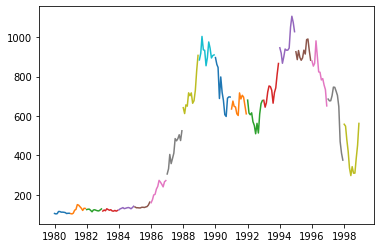

In [12]:

from matplotlib import pyplot as plt
for i in range(1980,1999):
    plt.plot(final_df['{}-01-01'.format(i):'{}-12-01'.format(i)])
plt.show()
plt.close()

In [13]:
ret = np.log(final_df / final_df.shift(1))
ret.iloc[0] = 0
ret.index = ret.index.to_period('M').to_timestamp()

In [14]:
dt_final = pd.DataFrame()
dt_final['Mkt'] = ret['1980-01':'2022-12-01']

In [15]:
rf = pd.read_csv('./risk_free.csv')
rf['RF'] = rf['RF'].astype('float')
rf['RF'] = rf['RF'] / 100

In [16]:
rf.set_index('Date', inplace=True)
rf.index = pd.to_datetime(rf.index)
rf = rf.sort_values(by='Date')

In [17]:
rf.index = rf.index.to_period('M').to_timestamp()
dt_final.index = dt_final.index.to_period('M').to_timestamp()
rf = rf['1980-01-01':'2022-12-01']

In [18]:
dt_final = pd.concat([dt_final,rf],1)

In [16]:
# https://fred.stlouisfed.org/series/INTDSRKRM193N

In [20]:
CPI = pd.read_csv('./CPI.csv')
CPI = CPI.set_index('Date')
CPI.index = pd.to_datetime(CPI.index)
CPI = CPI['1980-01-01':'2022-12-01']

In [21]:
dt_final = pd.concat([dt_final,CPI],1)
dt_final = dt_final.astype(float)

In [22]:
dt_final['RF'] = dt_final['RF'] / 12 # monthly로 바꿔야함

In [23]:
dt_final = dt_final[~dt_final.index.duplicated(keep="first")]

In [24]:
dt_final.to_csv('./data.csv')

In [25]:
dt_snp = pd.read_csv('./data_snp.csv')
dt_snp = dt_snp.set_index('Date')

In [26]:
dt_snp